# Apply pixel classifier on all images in a folder,  create corresponding mask

In [1]:
from scipy import ndimage
from scipy import signal
from skimage.morphology import binary_erosion
import sys

from sklearn.ensemble import RandomForestClassifier
import glob
import os
import pickle as pkl
from skimage import io
#from csbdeep.utils import normalize
import numpy as np
import skimage
from skimage.morphology import square
import scipy
from skimage.segmentation import expand_labels
import matplotlib.pyplot as plt
import pandas as pd
sys.path.append(os.path.realpath('/Users/max/Desktop/Scripts_for_max/'))
from semantic_segmentation import init_VGG16_pyramid, fd_VGG16_pyramid
from magicgui import magicgui
import napari
import re

print('all modules imported')


/Users/max/opt/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
def spot_mask_from_labels(labels):
    '''takes label mask, shrinks objects and subtracts from original image.'''
    stim_width = 25
    footprint = np.ones((stim_width,stim_width))
    labels_b = labels>0
    labels_b_ero = binary_erosion(labels_b,footprint)
    labels_b_sub = np.logical_xor(labels_b,labels_b_ero)
    labels_b_sub = labels_b_sub.astype('uint8')
    labels_sub = np.multiply(labels_b_sub,labels)
    
    df = pd.DataFrame()
    props = skimage.measure.regionprops(labels)
    for prop in props[:]:
        df_spot = pd.DataFrame({'cell_label': [prop.label],'cell_x': [prop.centroid[0]], 'cell_y':[prop.centroid[1]], 'cell_area': [prop.area],'stim_width':[stim_width]})
        df = df.append(df_spot)

    return labels_b_sub,df

def frame_to_labels(frame):
    #f_h2b = frame[1,:,:].copy()
    f_h2b = frame[:,:].copy()
    f_h2b_scaled = normalize(f_h2b, 5,95)
    features = fd_VGG16_pyramid(f_h2b_scaled,models,shapes)
    to_predict = features.reshape(np.shape(features)[0]*np.shape(features)[1],np.shape(features)[2])
    prediction_list = clf.predict_proba(to_predict)[:,0]
    prediction_img = np.reshape(prediction_list, f_h2b_scaled.shape)
    #now run watershed on segmentaion, using no seed
    prediction_img = prediction_img>0.5
    prediction_img = skimage.morphology.erosion(prediction_img, square(5))
    prediction_img = skimage.morphology.remove_small_objects(prediction_img, min_size = 100**2)
    prediction_img = scipy.ndimage.morphology.binary_fill_holes(prediction_img)
        
    #labels = skimage.segmentation.watershed(-distance_img, mask = prediction_img)#, mask=prediction_img>0.5)
    labels = skimage.segmentation.watershed(~prediction_img, mask = prediction_img)

    return labels


### Import the classifier you want to use

In [3]:
file = open("/Users/max/Desktop/Scripts_for_max/classifier_max_2021-10-15_DLC1.pkl", "rb")
clf = pkl.load(file)
file.close()

In [16]:
file = open("/Users/max/Desktop/Scripts_for_max/classifier_max_2021-10-15_DLC1.pkl", "wb")
pkl.dump(clf, file)

file.close()

In [11]:
input_folder = '/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/'
output_folder_segmentation = '/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/ratio/'
#change experiment ID
Experiment_ID='FRET_13'
ch1_flatfield=io.imread('/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_13/flatfield/Averaged_FRET_flatfield.tif')
ch2_flatfield=io.imread('/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_13/flatfield/Averaged_CFP_flatfield.tif')
ch1_darkcurrent=io.imread('/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_14/filtertest/dark_current/Averaged_FRET_darkcurrent.tif')
ch2_darkcurrent=io.imread('/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_14/filtertest/dark_current/Averaged_CFP_darkcurrent.tif')

ch2='CFP'
ch1='FRET'

In [12]:
#CFP_corrected, masked_frame=flatfield_preprocessing(CFPframe, ch2_flatfield, frame_segmented)

def normalize(x, pmin=3, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """Percentile-based image normalization."""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)
def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =                   (x - mi) / ( ma - mi + eps )

    if clip:
        x = np.clip(x,0,1)

    return x
def bg_calculation(masked_frame):
    #hist, bins = np.histogram(masked_frame, bins=50)
    #width = 0.7 * (bins[1] - bins[0])
    #center = (bins[:-1] + bins[1:]) / 2
#    plt.bar(center, hist, align='center', width = width)
#    plt.ylim(0,450000)
#    plt.xlim(0,750)
    #bg = np.percentile(bins[0:30], 75)
    bg = np.median(masked_frame)
    return bg

# Actual background substraction
def background_sub(image, bg):
    global bg_mask
    bg_z_image = image - bg
    bg_mask = np.zeros_like(bg_z_image)
    bg_mask[bg_z_image > 0] = 1
    bg_z_image = bg_mask*bg_z_image
    bg_z_image = bg_z_image.astype(np.float32) 
    return bg_z_image

def bg_correct(image, masked_frame):
    bg_calc = bg_calculation(masked_frame)
    corr_im = background_sub(image,bg_calc)
    return corr_im
def flatfield_preprocessing(img, flatfield, frame_segmented, dark_current):
    #flatfield=signal.medfilt(flatfield, kernel_size=[11,11])
    dark_current=ndimage.median_filter(dark_current, size=8)
    dark_corrected=bg_correct(img, dark_current)#img - dark_current
    
    flatfield=ndimage.median_filter(flatfield, size=8)
    imgcorrected=np.divide(dark_corrected, flatfield)
    #grow the background mask

    frame_segmented=ndimage.morphology.binary_dilation(frame_segmented, iterations=30)
    

    
    
    masked_frame=imgcorrected.copy()
    masked_frame[frame_segmented>0]=0
    
    #bg_corrected=dark_corrected
    bg_corrected=bg_correct(imgcorrected, masked_frame)
    
    #plt.imshow(bg_corrected, cmap = 'gray')
    return bg_corrected, masked_frame
    #return imgcorrected, masked_frame
def image_ratioing(f, c, path, filename):
    '''
    needs as inputs the fret image, the CFP image, the path to the images, the filename of one of the images
    . needs to be called after flatfield correction
    '''
    #print(type(f))
    #print(type(c))    
    FRETratio=np.divide(f, c)
    #print('fretframe')
    #plt.imshow(f, cmap = 'gray')
    #plt.show()
    #print('CFPframe')
    #plt.imshow(c, cmap = 'gray')
    #plt.show()


    #print('saving: ', savestr)
    return FRETratio

print('defined preprocessing functions' )



defined preprocessing functions


### Set input and output folders

### Search images

In [13]:
FRETfilenames = sorted(glob.glob(os.path.join(input_folder,'*FRET*.TIF')))
CFPfilenames = sorted(glob.glob(os.path.join(input_folder,'*CFP*.TIF')))
print(f'Found {len(FRETfilenames)} input files.')
print(f'Last file: {FRETfilenames[-2]}')
raw = io.imread(FRETfilenames[-1])

Found 256 input files.
Last file: /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/flatfield_4_w26TIRFFRETacceptor.TIF


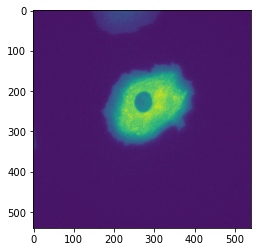

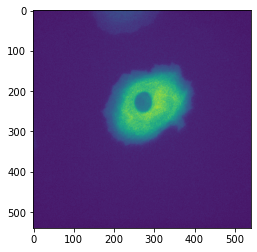

In [14]:
fov = 0
raw = io.imread(FRETfilenames[0])
frame = raw
norm_min = 5
norm_max = 95
f_h2b = frame[:,:].copy()
annotation_frame = normalize(f_h2b, norm_min,norm_max)
norm_min = 5
norm_max = 95
shapes = [(512,512),(64,64),(32,32)]
#shapes = [(540,540),(68,68),(32,32)]
models = init_VGG16_pyramid(shapes)
plt.imshow(frame)
plt.show()
plt.imshow(io.imread(CFPfilenames[0]))
plt.show()

In [15]:
#create the classifier
clf = RandomForestClassifier(random_state=0)

# create feature extractor and apply 
#shapes = [(1024,1024),(512,512),(256,256),(128,128),(64,64)]
shapes = [(512,512),(64,64),(32,32)]
models = init_VGG16_pyramid(shapes)
features = fd_VGG16_pyramid(annotation_frame,models,shapes)


@magicgui(call_button='train classifier')
def clf_widget():
    #run everytime the train button is pressed
    #extract the labels
    annotations = np.array(labels_layer.data)
    X,y = annotations_to_tensor(features,annotations)
    clf.fit(X, y) #train the classifier on the new labels
    #now predict the rest of the image with the new clf
    to_predict = features.reshape(np.shape(features)[0]*np.shape(features)[1],np.shape(features)[2])
    prediction_list = clf.predict_proba(to_predict)[:,0]
    prediction_img = np.reshape(prediction_list, annotation_frame.shape)
    
    #display the new prediciton
    prediction_layer.visible = True
    prediction_layer.data = prediction_img
    return clf

def annotations_to_tensor(feature_matrix,mask):
    #feature matrix dim: [x,y,nb_features]
    #possible mask elements: 0: not annotated, int[1,2]: class annotation
    y_labels=[] #where class labels are stored
    X_features=[] #where feature vectors are stored
    for x,y in np.argwhere(mask!=0):
        y_labels.append(mask[x,y])
        #X_features.append(feature_matrix[x,y,:])
        X_features.append(feature_matrix[x,y,])
    #turn list into np array
    X_features = np.asarray(X_features)
    return X_features,y_labels

viewer = napari.view_image(annotation_frame, name="My Image")


labels_layer = viewer.add_labels(np.zeros_like(annotation_frame).astype(int), seed = 0)
viewer.window.add_dock_widget(clf_widget)
prediction_layer = viewer.add_image(np.zeros_like(annotation_frame),colormap='PiYG')
prediction_layer.visible = False
prediction_layer.name = "Classifier prediction"
napari.run()

/Users/max/opt/anaconda3/lib/python3.7/site-packages/napari/_qt/__init__.py:54: UserWarning: 

IMPORTANT:
You are using QT version 5.12.1, but version 5.12 was also found in your environment.
This usually happens when you 'conda install' something that also depends on PyQt
*after* you have pip installed napari (such as jupyter notebook).
You will likely run into problems and should create a fresh environment.
If you want to install conda packages into the same environment as napari,
please add conda-forge to your channels: https://conda-forge.org

  warn(message=warn_message)


In [17]:
## Create the required folders 
def create_folders(path, directory):
    for i in directory:
        iDir=os.path.join(path, i)
        try:
            if not os.path.exists(iDir):
                os.makedirs(iDir)
                print('Created folder: ', iDir)
            else: 
                print('Folder: ', iDir, 'already exists')
        except OSError:
            print ('Error: Creating directory. ' + iDir)
required_folders = ['mask', 'stim_mask', 'ratio'] #leave this

create_folders(output_folder_segmentation,required_folders)  #leave this

Created folder:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/ratio/mask
Created folder:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/ratio/stim_mask
Created folder:  /Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/ratio/ratio


### Run the segmentation on all images

/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_100_w26TIRFFRETacceptor.TIF
frame_segmented


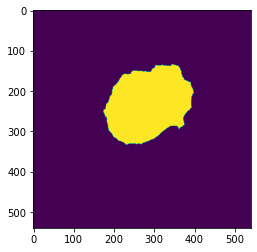

frame_mask


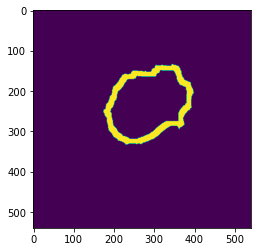

masked_frame


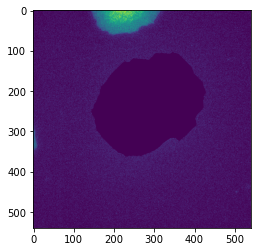

FRET_corrected


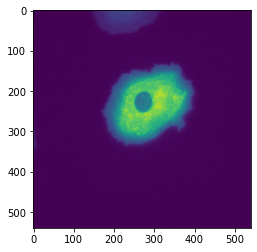

CFP_corrected


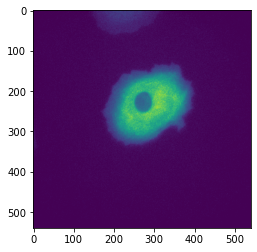

processing file  0  of  256
FRETratio


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


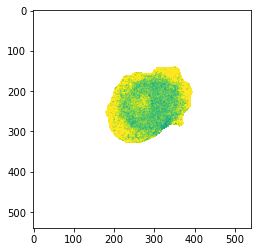

/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_101_w26TIRFFRETacceptor.TIF
processing file  1  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_102_w26TIRFFRETacceptor.TIF
processing file  2  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_103_w26TIRFFRETacceptor.TIF
processing file  3  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_104_w26TIRFFRETacceptor.TIF
processing file  4  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_105_w26TIRFFRETacceptor.TIF
processing file  5  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_106_w26TIRFFRETacceptor.TIF
processing file  6  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_107_w26TIRFFRETacceptor.TIF
processing file  7  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_108_w26TIRFFRETacceptor.TIF
processing file  8  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_109_w26TIRFFRETacceptor.TIF
processing file  9  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_10_w26TIRFFRETacceptor.TIF
processing file  10  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_110_w26TIRFFRETacceptor.TIF
processing file  11  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_111_w26TIRFFRETacceptor.TIF
processing file  12  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_112_w26TIRFFRETacceptor.TIF
processing file  13  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_113_w26TIRFFRETacceptor.TIF
processing file  14  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_114_w26TIRFFRETacceptor.TIF
processing file  15  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_115_w26TIRFFRETacceptor.TIF
processing file  16  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_116_w26TIRFFRETacceptor.TIF
processing file  17  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_117_w26TIRFFRETacceptor.TIF
processing file  18  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_118_w26TIRFFRETacceptor.TIF
processing file  19  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_119_w26TIRFFRETacceptor.TIF
processing file  20  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_11_w26TIRFFRETacceptor.TIF
processing file  21  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_120_w26TIRFFRETacceptor.TIF
processing file  22  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_121_w26TIRFFRETacceptor.TIF
processing file  23  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_122_w26TIRFFRETacceptor.TIF
processing file  24  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_123_w26TIRFFRETacceptor.TIF
processing file  25  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_124_w26TIRFFRETacceptor.TIF
processing file  26  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_125_w26TIRFFRETacceptor.TIF
processing file  27  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_126_w26TIRFFRETacceptor.TIF
processing file  28  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_127_w26TIRFFRETacceptor.TIF
processing file  29  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_128_w26TIRFFRETacceptor.TIF
processing file  30  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_129_w26TIRFFRETacceptor.TIF
processing file  31  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_12_w26TIRFFRETacceptor.TIF
processing file  32  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_130_w26TIRFFRETacceptor.TIF
processing file  33  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_131_w26TIRFFRETacceptor.TIF
processing file  34  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_132_w26TIRFFRETacceptor.TIF
processing file  35  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_133_w26TIRFFRETacceptor.TIF
processing file  36  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_13_w26TIRFFRETacceptor.TIF
processing file  37  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_14_w26TIRFFRETacceptor.TIF
processing file  38  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_15_w26TIRFFRETacceptor.TIF
processing file  39  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_16_w26TIRFFRETacceptor.TIF
processing file  40  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_17_w26TIRFFRETacceptor.TIF
processing file  41  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_18_w26TIRFFRETacceptor.TIF
processing file  42  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_19_w26TIRFFRETacceptor.TIF
processing file  43  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_1_w26TIRFFRETacceptor.TIF
processing file  44  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_20_w26TIRFFRETacceptor.TIF
processing file  45  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_21_w26TIRFFRETacceptor.TIF
processing file  46  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_22_w26TIRFFRETacceptor.TIF
processing file  47  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_23_w26TIRFFRETacceptor.TIF
processing file  48  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_24_w26TIRFFRETacceptor.TIF
processing file  49  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_25_w26TIRFFRETacceptor.TIF
processing file  50  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_26_w26TIRFFRETacceptor.TIF
processing file  51  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_27_w26TIRFFRETacceptor.TIF
processing file  52  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_28_w26TIRFFRETacceptor.TIF
processing file  53  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_29_w26TIRFFRETacceptor.TIF
processing file  54  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_2_w26TIRFFRETacceptor.TIF
processing file  55  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_30_w26TIRFFRETacceptor.TIF
processing file  56  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_31_w26TIRFFRETacceptor.TIF
processing file  57  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_32_w26TIRFFRETacceptor.TIF
processing file  58  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_33_w26TIRFFRETacceptor.TIF
processing file  59  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_34_w26TIRFFRETacceptor.TIF
processing file  60  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_35_w26TIRFFRETacceptor.TIF
processing file  61  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_36_w26TIRFFRETacceptor.TIF
processing file  62  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_37_w26TIRFFRETacceptor.TIF
processing file  63  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_38_w26TIRFFRETacceptor.TIF
processing file  64  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_39_w26TIRFFRETacceptor.TIF
processing file  65  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_3_w26TIRFFRETacceptor.TIF
processing file  66  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_40_w26TIRFFRETacceptor.TIF
processing file  67  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_41_w26TIRFFRETacceptor.TIF
processing file  68  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_42_w26TIRFFRETacceptor.TIF
processing file  69  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_43_w26TIRFFRETacceptor.TIF
processing file  70  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_44_w26TIRFFRETacceptor.TIF
processing file  71  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_45_w26TIRFFRETacceptor.TIF
processing file  72  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_46_w26TIRFFRETacceptor.TIF
processing file  73  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_47_w26TIRFFRETacceptor.TIF
processing file  74  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_48_w26TIRFFRETacceptor.TIF
processing file  75  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_49_w26TIRFFRETacceptor.TIF
processing file  76  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_4_w26TIRFFRETacceptor.TIF
processing file  77  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_50_w26TIRFFRETacceptor.TIF
processing file  78  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_51_w26TIRFFRETacceptor.TIF
processing file  79  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_52_w26TIRFFRETacceptor.TIF
processing file  80  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_53_w26TIRFFRETacceptor.TIF
processing file  81  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_54_w26TIRFFRETacceptor.TIF
processing file  82  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_55_w26TIRFFRETacceptor.TIF
processing file  83  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_56_w26TIRFFRETacceptor.TIF
processing file  84  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_57_w26TIRFFRETacceptor.TIF
processing file  85  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_58_w26TIRFFRETacceptor.TIF
processing file  86  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_59_w26TIRFFRETacceptor.TIF
processing file  87  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_5_w26TIRFFRETacceptor.TIF
processing file  88  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_60_w26TIRFFRETacceptor.TIF
processing file  89  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_61_w26TIRFFRETacceptor.TIF
processing file  90  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_62_w26TIRFFRETacceptor.TIF
processing file  91  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_63_w26TIRFFRETacceptor.TIF
processing file  92  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_64_w26TIRFFRETacceptor.TIF
processing file  93  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_65_w26TIRFFRETacceptor.TIF
processing file  94  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_66_w26TIRFFRETacceptor.TIF
processing file  95  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_67_w26TIRFFRETacceptor.TIF
processing file  96  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_68_w26TIRFFRETacceptor.TIF
processing file  97  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_69_w26TIRFFRETacceptor.TIF
processing file  98  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_6_w26TIRFFRETacceptor.TIF
processing file  99  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_70_w26TIRFFRETacceptor.TIF
processing file  100  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_71_w26TIRFFRETacceptor.TIF
processing file  101  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_72_w26TIRFFRETacceptor.TIF
processing file  102  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_73_w26TIRFFRETacceptor.TIF
processing file  103  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_74_w26TIRFFRETacceptor.TIF
processing file  104  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_75_w26TIRFFRETacceptor.TIF
processing file  105  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_76_w26TIRFFRETacceptor.TIF
processing file  106  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_77_w26TIRFFRETacceptor.TIF
processing file  107  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_78_w26TIRFFRETacceptor.TIF
processing file  108  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_79_w26TIRFFRETacceptor.TIF
processing file  109  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_7_w26TIRFFRETacceptor.TIF
processing file  110  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_80_w26TIRFFRETacceptor.TIF
processing file  111  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_81_w26TIRFFRETacceptor.TIF
processing file  112  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_82_w26TIRFFRETacceptor.TIF
processing file  113  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_83_w26TIRFFRETacceptor.TIF
processing file  114  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_84_w26TIRFFRETacceptor.TIF
processing file  115  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_85_w26TIRFFRETacceptor.TIF
processing file  116  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_86_w26TIRFFRETacceptor.TIF
processing file  117  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_87_w26TIRFFRETacceptor.TIF
processing file  118  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_88_w26TIRFFRETacceptor.TIF
processing file  119  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_89_w26TIRFFRETacceptor.TIF
processing file  120  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_8_w26TIRFFRETacceptor.TIF
processing file  121  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_90_w26TIRFFRETacceptor.TIF
processing file  122  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_91_w26TIRFFRETacceptor.TIF
processing file  123  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_92_w26TIRFFRETacceptor.TIF
processing file  124  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_93_w26TIRFFRETacceptor.TIF
processing file  125  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_94_w26TIRFFRETacceptor.TIF
processing file  126  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_95_w26TIRFFRETacceptor.TIF
processing file  127  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_96_w26TIRFFRETacceptor.TIF
processing file  128  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_97_w26TIRFFRETacceptor.TIF
processing file  129  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_98_w26TIRFFRETacceptor.TIF
processing file  130  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_99_w26TIRFFRETacceptor.TIF
processing file  131  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/1B2_9_w26TIRFFRETacceptor.TIF
processing file  132  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_100_w26TIRFFRETacceptor.TIF
processing file  133  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_101_w26TIRFFRETacceptor.TIF
processing file  134  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_102_w26TIRFFRETacceptor.TIF
processing file  135  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_103_w26TIRFFRETacceptor.TIF
processing file  136  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_104_w26TIRFFRETacceptor.TIF
processing file  137  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_105_w26TIRFFRETacceptor.TIF
processing file  138  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_106_w26TIRFFRETacceptor.TIF
processing file  139  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_107_w26TIRFFRETacceptor.TIF
processing file  140  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_108_w26TIRFFRETacceptor.TIF
processing file  141  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_109_w26TIRFFRETacceptor.TIF
processing file  142  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_10_w26TIRFFRETacceptor.TIF
processing file  143  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_11_w26TIRFFRETacceptor.TIF
processing file  144  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_12_w26TIRFFRETacceptor.TIF
processing file  145  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_13_w26TIRFFRETacceptor.TIF
processing file  146  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_14_w26TIRFFRETacceptor.TIF
processing file  147  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_15_w26TIRFFRETacceptor.TIF
processing file  148  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_16_w26TIRFFRETacceptor.TIF
processing file  149  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_17_w26TIRFFRETacceptor.TIF
processing file  150  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_18_w26TIRFFRETacceptor.TIF
processing file  151  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_19_w26TIRFFRETacceptor.TIF
processing file  152  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_1_w26TIRFFRETacceptor.TIF
processing file  153  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_20_w26TIRFFRETacceptor.TIF
processing file  154  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_21_w26TIRFFRETacceptor.TIF
processing file  155  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_22_w26TIRFFRETacceptor.TIF
processing file  156  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_23_w26TIRFFRETacceptor.TIF
processing file  157  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_24_w26TIRFFRETacceptor.TIF
processing file  158  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_25_w26TIRFFRETacceptor.TIF
processing file  159  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_26_w26TIRFFRETacceptor.TIF
processing file  160  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_27_w26TIRFFRETacceptor.TIF
processing file  161  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_28_w26TIRFFRETacceptor.TIF
processing file  162  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_29_w26TIRFFRETacceptor.TIF
processing file  163  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_2_w26TIRFFRETacceptor.TIF
processing file  164  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_30_w26TIRFFRETacceptor.TIF
processing file  165  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_31_w26TIRFFRETacceptor.TIF
processing file  166  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_32_w26TIRFFRETacceptor.TIF
processing file  167  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_33_w26TIRFFRETacceptor.TIF
processing file  168  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_34_w26TIRFFRETacceptor.TIF
processing file  169  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_35_w26TIRFFRETacceptor.TIF
processing file  170  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_36_w26TIRFFRETacceptor.TIF
processing file  171  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_37_w26TIRFFRETacceptor.TIF
processing file  172  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_38_w26TIRFFRETacceptor.TIF
processing file  173  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_39_w26TIRFFRETacceptor.TIF
processing file  174  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_3_w26TIRFFRETacceptor.TIF
processing file  175  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_40_w26TIRFFRETacceptor.TIF
processing file  176  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_41_w26TIRFFRETacceptor.TIF
processing file  177  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_42_w26TIRFFRETacceptor.TIF
processing file  178  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_43_w26TIRFFRETacceptor.TIF
processing file  179  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_44_w26TIRFFRETacceptor.TIF
processing file  180  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_45_w26TIRFFRETacceptor.TIF
processing file  181  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_46_w26TIRFFRETacceptor.TIF
processing file  182  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_47_w26TIRFFRETacceptor.TIF
processing file  183  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_48_w26TIRFFRETacceptor.TIF
processing file  184  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_49_w26TIRFFRETacceptor.TIF
processing file  185  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_4_w26TIRFFRETacceptor.TIF
processing file  186  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_50_w26TIRFFRETacceptor.TIF
processing file  187  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_51_w26TIRFFRETacceptor.TIF
processing file  188  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_52_w26TIRFFRETacceptor.TIF
processing file  189  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_53_w26TIRFFRETacceptor.TIF
processing file  190  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_54_w26TIRFFRETacceptor.TIF
processing file  191  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_55_w26TIRFFRETacceptor.TIF
processing file  192  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_56_w26TIRFFRETacceptor.TIF
processing file  193  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_57_w26TIRFFRETacceptor.TIF
processing file  194  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_58_w26TIRFFRETacceptor.TIF
processing file  195  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_59_w26TIRFFRETacceptor.TIF
processing file  196  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_5_w26TIRFFRETacceptor.TIF
processing file  197  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_60_w26TIRFFRETacceptor.TIF
processing file  198  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_61_w26TIRFFRETacceptor.TIF
processing file  199  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_62_w26TIRFFRETacceptor.TIF
processing file  200  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_63_w26TIRFFRETacceptor.TIF
processing file  201  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_64_w26TIRFFRETacceptor.TIF
processing file  202  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_65_w26TIRFFRETacceptor.TIF
processing file  203  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_66_w26TIRFFRETacceptor.TIF
processing file  204  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_67_w26TIRFFRETacceptor.TIF
processing file  205  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_68_w26TIRFFRETacceptor.TIF
processing file  206  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_69_w26TIRFFRETacceptor.TIF
processing file  207  of  256


/Users/max/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_7/REF52_6_w26TIRFFRETacceptor.TIF


KeyboardInterrupt: 

In [18]:
timelapse=False
shapes = [(512,512),(64,64),(32,32)]
models = init_VGG16_pyramid(shapes)
frame_segmented = frame_to_labels(raw)

if timelapse == False:
   pattern = re.compile('(?P<Imagename>[^w]*).*(?P<Channel>FRET|CFP).*')
if timelapse == True:       
   pattern = re.compile('(?P<Imagename>[^w]*).*(?P<Channel>FRET|CFP).*(?P<Site>s[0-9]+)_t(?P<Timepoint>[0-9]+).*')
datatable=pd.DataFrame(columns=[ 'Experiment_ID','Filename', 'Cell_ID', 'Classifier',
                                'MeanIntensity_stimmaskRatio','MeanIntensity_cellmaskRatio', 
                                'MeanIntensity_CFP'])
for i, filename in enumerate(FRETfilenames):
    FRETframe = io.imread(filename)
    #get the pattern from the filename
    if timelapse == False:
        FRETname=re.search(pattern, filename.split('/')[-1]).group('Imagename')
    if timelapse == True:       
        FRETname=re.search(pattern, filename.split('/')[-1]).group('Imagename', 'Site', 'Timepoint')
    print(filename)
    #make segmentation
    # if input image has multiple channels, select the correct one here:
    #frame = frame[channel_nb,:,:] #where channel_nb is the channel you want to segment on
    frame_segmented = frame_to_labels(FRETframe)
    frame_mask, table = spot_mask_from_labels(frame_segmented)
   
    #show first segmentation

        
    #create a mask for background substraction based on segmentation    


    FRET_corrected, masked_frame=flatfield_preprocessing(FRETframe, ch1_flatfield, frame_segmented, ch1_darkcurrent)
    io.imsave(os.path.join(output_folder_segmentation, 'ratio', os.path.basename(filename).split('.')[0] + 'FRET'+'.tiff'), FRET_corrected, check_contrast=False)

    #FRET_corrected= signal.medfilt(FRET_corrected, kernel_size=[3,3])
    
    if i == 0:
        print('frame_segmented')
        plt.imshow(frame_segmented)
        plt.show()
        print('frame_mask')
        plt.imshow(frame_mask)
        plt.show()
        print('masked_frame')
        plt.imshow(masked_frame)
        plt.show()
        print('FRET_corrected')
        plt.imshow(FRET_corrected)
        plt.show()
        #break
    FRET_masked=FRET_corrected.copy()
    FRET_masked[frame_segmented==0]=0
    io.imsave(os.path.join(output_folder_segmentation,'stim_mask', os.path.basename(filename).split('.')[0]+ 'stimmask' +'.tiff'), frame_mask, check_contrast=False)
    io.imsave(os.path.join(output_folder_segmentation, 'mask', os.path.basename(filename).split('.')[0] + 'mask'+'.tiff'), frame_segmented, check_contrast=False)
    for CFP in CFPfilenames:
        CFPframe=io.imread(CFP)
        if timelapse==False:
            CFPname=re.search(pattern, CFP.split('/')[-1]).group('Imagename')
        if timelapse == True:       
            CFPname=re.search(pattern, CFP.split('/')[-1]).group('Imagename','Site', 'Timepoint')
        
        if CFPname==FRETname:
            try:
                CFP_corrected, masked_frame=flatfield_preprocessing(CFPframe, ch2_flatfield, frame_segmented, ch2_darkcurrent)
                #CFP_corrected=signal.medfilt(CFP_corrected, kernel_size=[3,3])
                io.imsave(os.path.join(output_folder_segmentation, 'ratio', os.path.basename(filename).split('.')[0] + 'CFP'+'.tiff'), CFP_corrected, check_contrast=False)

                if i==0:
                    print ('CFP_corrected')
                    plt.imshow(CFP_corrected)
                    plt.show()
                CFP_masked=CFP_corrected.copy()    
                CFP_masked[frame_segmented==0]=0
                print('processing file ', i, ' of ', len(FRETfilenames) )              
                FRETratio=image_ratioing(FRET_masked, CFP_masked, os.path.join(output_folder_segmentation, 'ratio'), filename.split('/')[-1])
                
                
                for f in np.unique(frame_segmented)[1:]:
                    if timelapse==False:
                        temp_data={'Experiment_ID': Experiment_ID, 'Filename':filename.split('/')[-1], 'Cell_ID':i, 
                                   'Classifier': filename.split('/')[-1].split('_')[0], 
                                   'MeanIntensity_stimmaskRatio': np.mean(np.ma.masked_invalid(FRETratio[(frame_mask>0) & (frame_segmented==f)])),
                                   'MeanIntensity_cellmaskRatio':np.mean(np.ma.masked_invalid(FRETratio[frame_segmented==f])),
                                   'MeanIntensity_CFP': np.mean(np.ma.masked_invalid(CFP_corrected[frame_segmented==f])),}
                    if timelapse==True:
                          temp_data={'Experiment_ID': Experiment_ID, 'Filename':''.join(re.search(pattern, filename.split('/')[-1]).group('Imagename', 'Site')),
                                     'Cell_ID':i, 
                                     'Timepoint': re.search(pattern, CFP.split('/')[-1]).group('Timepoint'),
                                     'Classifier': filename.split('/')[-1].split('_')[0], 
                                     'MeanIntensity_stimmaskRatio': np.mean(np.ma.masked_invalid(FRETratio[(frame_mask>0) & (frame_segmented==f)])),
                                     'MeanIntensity_cellmaskRatio':np.mean(np.ma.masked_invalid(FRETratio[frame_segmented==f])), 
                                     'MeanIntensity_CFP': np.mean(np.ma.masked_invalid(CFP_corrected[frame_segmented==f])),
                                      'CellEdge_relativeRatio': np.mean(np.ma.masked_invalid(FRETratio[(frame_mask>0) & (frame_segmented==f)]))/np.mean(np.ma.masked_invalid(FRETratio[frame_segmented==f]))}
                    datatable=datatable.append(temp_data, ignore_index=True)
                    
                    FRETratio=ndimage.median_filter(FRETratio, size=2)  
                    io.imsave(os.path.join(output_folder_segmentation, 'ratio', os.path.basename(filename).split('.')[0] + 'ratio'+'.tiff'), FRETratio, check_contrast=False)


                if i==0:
                    #print('FRETframe')
                    #plt.imshow(FRETframe)
                    #plt.show()
                    print('FRETratio')
                    
                    plt.imshow(FRETratio, cmap='viridis', vmax=1.8)
                    plt.show()
                    
                    
                #break
            except OSError as e:
                print (e) 
    datatable.to_csv(os.path.join(output_folder_segmentation, Experiment_ID+'.csv'))
    #break
datatable=datatable[datatable['MeanIntensity_cellmaskRatio']!='--']
datatable['MeanIntensity_cellmaskRatio']=datatable['MeanIntensity_cellmaskRatio'].astype(float)
datatable['MeanIntensity_stimmaskRatio']=datatable['MeanIntensity_stimmaskRatio'].astype(float)
datatable['MeanIntensity_CFP']=datatable['MeanIntensity_CFP'].astype(float)
datatable.to_csv(os.path.join(output_folder_segmentation, Experiment_ID+'.csv'))
#datatable.to_csv(os.path.join(output_folder_segmentation, Experiment_ID+'.csv'))
print('Finished processing all images!')

In [131]:
                    temp_data={'Experiment_ID': Experiment_ID, 'Filename':filename.split('/')[-1], 'Cell_ID':i, 'MeanIntensity_stimmaskRatio': np.mean(FRETratio([frame_mask>0]&[frame_segmented[i]])),
                    'MeanIntensity_cellmaskRatio':np.mean(FRETratio[frame_segmented[i]]), 'MeanIntensity_CFP':np.mean(CFP_corrected[frame_segmented[i]])}

In [89]:

print(np.mean(np.ma.masked_invalid(FRETratio[tuple([frame_mask>0] and [frame_segmented==i])])))
print(np.mean(np.ma.masked_invalid(FRETratio[frame_segmented==i])))


1.225992374572406
1.225992374572406


In [102]:
len(FRETratio[(frame_mask>0) & (frame_segmented==i)])

30661

In [108]:
FRETratio[frame_segmented==i])

0

In [103]:
filename.split('/')[-1].split('_')[0]

'flatfield'

In [116]:
np.mean(np.ma.masked_invalid(FRETratio[(frame_mask>0) & (frame_segmented==f)]))

1.3073466566957381

In [111]:
print(i)

63


In [117]:
np.mean(np.ma.masked_invalid(FRETratio[frame_segmented==i]))

1.376080839120827